# Pré-Processamento

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import pickle as pkl
import itertools
from tqdm.notebook import trange, tqdm
import sys, warnings
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt
#!pip3 install fastplot
#import fastplot
import networkx as nx
!pip3 install python-igraph
import igraph as ig
import math
from itertools import chain
random.seed(2022)
import joblib
from tqdm import tqdm
import re
import hashlib
import psycopg2
from psycopg2 import extras as ex
from datetime import datetime, timezone
import time
import pytz
from time import mktime
from datetime import datetime
import time

# Pacotes para pre-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Pacotes para treino, teste e validação
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as multiple_scores
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# Algoritmos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

In [ ]:
# Determine the path of dataset
PROJECT_PATH = '<place-holder>'
DATA_PATH = PROJECT_PATH + 'Uncompressed-Files/'
CSV_PATH = PROJECT_PATH + 'CSV-Entities/'
PIPELINE_PATH = PROJECT_PATH + 'Pipeline-Files/'
TRAIN_PATH_15 = PROJECT_PATH + 'Time-Windows/15-minutes-window/Train-TimeWindows/'
TEST_PATH_15 = PROJECT_PATH + 'Time-Windows/15-minutes-window/Test-TimeWindows/'
TRAIN_PATH_10 = PROJECT_PATH + 'Time-Windows/10-minutes-window/Train-TimeWindows/'
TEST_PATH_10 = PROJECT_PATH + 'Time-Windows/10-minutes-window/Test-TimeWindows/'
TRAIN_PATH_5 = PROJECT_PATH + 'Time-Windows/5-minutes-window/Train-TimeWindows/'
TEST_PATH_5 = PROJECT_PATH + 'Time-Windows/5-minutes-window/Test-TimeWindows/'
print("\nDATA FOLDER: ")
!ls -lah $DATA_PATH
print("\nCSV FOLDER: ")
!ls -lah $CSV_PATH

In [ ]:
CONSOLIDATED = 'consolidated/'
!mkdir $CONSOLIDATED

FILTERED_CONSOLIDATED = 'filtered_consolidated/'
!mkdir $FILTERED_CONSOLIDATED

NOISE_CONSOLIDATED = 'noise_consolidated/'
!mkdir $NOISE_CONSOLIDATED

BASE = 'base/'
!mkdir $BASE

CONCAT = 'concat/'
!mkdir $CONCAT

BACKBONE = 'backbone/'
!mkdir $BACKBONE

FILTERED = 'filtered/'
!mkdir $FILTERED

NOISE = 'noise/'
!mkdir $NOISE

# Funções

In [ ]:
def disparity_filter(table, undirected = True):
    table_sum = table.groupby(table["src"]).sum().reset_index()
    table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
    table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
    table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
    table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
        table = table.drop("score_min", 1)
        #   table = table.drop("variance_max", 1)
    return table[["src", "trg", "nij", "score"]]

def read(filename, column_of_interest, triangular_input = False, consider_self_loops = False, undirected = True, drop_zeroes = False):
    """Reads a field separated input file into the internal backboning format (a Pandas Dataframe).
    The input file should have three or more columns (default separator: tab).
    The input file must have a one line header with the column names.
    There must be two columns called 'src' and 'trg', indicating the origin and destination of the interaction.
    All other columns must contain integer or floats, indicating the edge weight.
    In case of undirected network, the edges have to be present in both directions with the same weights, or set triangular_input to True.

    Args:
    filename (str): The path to the file containing the edges.
    column_of_interest (str): The column name identifying the weight that will be used for the backboning.

    KWArgs:
    triangular_input (bool): Is the network undirected and are the edges present only in one direction? default: False
    consider_self_loops (bool): Do you want to consider self loops when calculating the backbone? default: True
    undirected (bool): Is the network undirected? default: False
    drop_zeroes (bool): Do you want to keep zero weighted connections in the network? Important: it affects methods based on degree, like disparity_filter. default: False
    sep (char): The field separator of the inout file. default: tab

    Returns:
    The parsed network data, the number of nodes in the network and the number of edges.
    """
    table = pd.read_csv(filename)
    table = table[["src", "trg", column_of_interest]]
    table.rename(columns = {column_of_interest: "nij"}, inplace = True)
    if drop_zeroes:
        table = table[table["nij"] > 0]
    if not consider_self_loops:
        table = table[table["src"] != table["trg"]]
    if triangular_input:
        table2 = table.copy()
        table2["new_src"] = table["trg"]
        table2["new_trg"] = table["src"]
        table2.drop("src", 1, inplace = True)
        table2.drop("trg", 1, inplace = True)
        table2 = table2.rename(columns = {"new_src": "src", "new_trg": "trg"})
        table = pd.concat([table, table2], axis = 0)
        table = table.drop_duplicates(subset = ["src", "trg"])
    original_nodes = len(set(table["src"]) | set(table["trg"]))
    original_edges = table.shape[0]
    if undirected:
        return table, original_nodes, original_edges / 2
    else:
        return table, original_nodes, original_edges

# Jaccard similarity
def compute_sim(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  union_size = len(task_i.union(task_j))
  return intersection_size / union_size

# Overlap similarity
def compute_sim_overlap(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  min_size = min(len(task_i), len(task_j))
  return intersection_size / min_size

def compute_sim_carlos(task_i, task_j):
  intersection_size = len(task_i.intersection(task_j))
  #...
  return intersection_size / len(task_j)

def compute_sim_carlos2(task_i, task_j):
  #TODO: task_j precisa ser o fluxo, e não todo o experimento a ser comparado
  return


def compute_metrics(path, scenario):
  G = []
  average_nodes_number = 0
  average_edges_number = 0
  average_weights_number = 0
  for i in range(100 * scenario,100 * (scenario + 1)):
    match path:
      case 'consolidated/':
        filename = 'scenario' + str(scenario) + '_graph' + str(i) + '_consolidated'
      case 'filtered_consolidated/':
        filename = 'Backbone_filtered_consolidated' + str(i) + '.edgelist'
      case 'noise_consolidated/':
        filename = 'Backbone_noise_consolidated' + str(i) + '.edgelist'
      case 'concat/':
        filename = 'scenario' + str(scenario) + '_graph' + str(i) + '_concat'
      case 'filtered/':
        filename = 'Backbone_filtered' + str(i) + '.edgelist'
      case 'noise/':
        filename = 'Backbone_noise' + str(i) + '.edgelist'
      case 'backbone/':
        filename = 'Backbone' + str(i) + '.edgelist'
      case _:
        print('Unknown path!')
        sys.exit(-1)
    df = pd.read_csv(path + filename)
    df.rename(columns = {'edge-type':'edgetype'}, inplace = True)
    df['isAnom'] = False
    match path:
      case 'consolidated/' | 'filtered_consolidated/' | 'noise_consolidated/':
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src-type',
              target='trg-type',
              edge_attr=['edgetype', 'nij', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )
      case 'concat/' | 'filtered/' | 'noise/':
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src',
              target='trg',
              edge_attr=['edgetype', 'nij', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )
      case 'backbone/':
        df.rename(columns = {'src-type':'srctype'}, inplace = True)
        df.rename(columns = {'trg-type':'trgtype'}, inplace = True)
        G.append(
            nx.from_pandas_edgelist(
              df,
              source='src',
              target='trg',
              edge_attr=['edgetype', 'nij', 'srctype', 'trgtype', 'isAnom'],
              create_using=nx.MultiDiGraph()
            )
        )

    average_nodes_number += G[i % 100].number_of_nodes()
    average_edges_number += G[i % 100].number_of_edges()
    average_weights_number += G[i % 100].size(weight='nij')


  average_nodes_number /= 100
  average_edges_number /= 100
  average_weights_number /= 100

  sd_nodes = 0
  sd_edges = 0
  sd_weights = 0
  for i in range(0,100):
    sd_nodes += pow(G[i].number_of_nodes() - average_nodes_number, 2) / 100
    sd_edges += pow(G[i].number_of_edges() - average_edges_number, 2) / 100
    sd_weights += pow(G[i].size(weight='nij') - average_weights_number, 2) / 100

  sd_nodes = math.sqrt(sd_nodes)
  sd_edges = math.sqrt(sd_edges)
  sd_weights = math.sqrt(sd_weights)

  return G, [average_nodes_number, average_edges_number, average_weights_number], [sd_nodes, sd_edges, sd_weights]

def print_nodes_path_freq(graph, number_of_edges):
  set_node_edge_path = []
  counter_total = 0
  counter_selective = 0
  for node1 in graph.nodes:
    for node2 in graph.nodes:
      if node1 != node2 and nx.has_path(graph, node1, node2):
        for path in nx.all_simple_edge_paths(graph, node1, node2):
          if(len(path) == number_of_edges):
            set_node_edge_path.append([])
            for p in path:
              edge = graph[p[0]][p[1]][p[2]]
              aux = tuple(zip(edge['srctype'], edge['trgtype'], edge['edgetype'], str(edge['nij'])))
              set_node_edge_path[counter_selective].append(aux)

            counter_selective = counter_selective + 1
          counter_total = counter_total + 1
  print(f'Paths that contains only {number_of_edges + 1} nodes: {counter_selective}')
  print(f'Total paths: {counter_total}')
  percentage = counter_selective / counter_total * 100
  print(f'Percentage of paths that contains {number_of_edges + 1} nodes: {percentage}')
  return set_node_edge_path

def get_score(y_test, y_pred, metric):
  precision,recall,fscore,support=multiple_scores(y_test, y_pred, average='macro', zero_division=1)
  accuracy = metrics.accuracy_score(y_test, y_pred)
  dict_scores = dict(zip(['precision', 'recall', 'fscore', 'accuracy', 'support'], [precision, recall, fscore, accuracy, support]))
  return dict_scores[metric]

def ns_time_to_datetime_ET(ns):
    """
    :param ns: int nano timestamp
    :return: datetime   format: 2013-10-10 23:40:00.000000000
    """
    tz = pytz.timezone('US/Eastern')
    dt = pytz.datetime.datetime.fromtimestamp(int(ns) // 1000000000, tz)
    s = dt.strftime('%Y-%m-%d__%H:%M:%S')
    s += '.' + str(int(int(ns) % 1000000000)).zfill(9)
    return s

In [ ]:
def backbone_pipeline(df_weighted, time_window):
  #df_weighted = pd.read_csv(TRAIN_PATH + train_graphs_time_windowed[0])
  #time_window = train_graphs_time_windowed[0][6:-4]
  # create dict
  dict_node2type = dict(zip(df_weighted['src-id'], df_weighted['src-type']))
  dict_node2type_temp = dict(zip(df_weighted['dst-id'], df_weighted['dst-type']))
  dict_node2type.update(dict_node2type_temp)
  del(dict_node2type_temp)

  # rename columns and create concat file
  # The concat file only have the concatenation of source-id and edge type column added
  df_base = df_weighted.copy(deep=True)
  df_base.rename(columns = {'src-id':'aux'}, inplace = True)
  df_base.rename(columns = {'dst-id':'trg'}, inplace = True)
  df_base.rename(columns = {'weight':'nij'}, inplace = True)
  df_base["src"] = df_base["aux"].astype(str) + "|" + df_base['edge-type'].astype(str)
  df_base["src-type"] = df_base["aux"].map(dict_node2type)
  df_base["trg-type"] = df_base["trg"].map(dict_node2type)
  filename = 'concat_theia_graph_' + str(time_window)
  df_base.to_csv(CONCAT + filename, index = False)
  del(df_base) # Deleted df_base because it's equal to df_concat created just below

  df_concat, original_nodes, original_edges = read(CONCAT + filename, 'nij', consider_self_loops = True, undirected = False)

  df_backbone = disparity_filter(df_concat, undirected = False)
  df_backbone[['src', 'edge-type']] = df_backbone["src"].apply(lambda x: pd.Series(str(x).split("|")))
  df_backbone['src'] = df_backbone['src'].astype(str)
  df_backbone["src-type"] = df_backbone["src"].map(dict_node2type)
  df_backbone["trg-type"] = df_backbone["trg"].map(dict_node2type)
  filename = "Backbone" + str(time_window) + ".edgelist"
  df_backbone.to_csv(BACKBONE + filename, index=False)
  df_consolidated = df_backbone.groupby(['src-type','trg-type','edge-type'])['nij'].sum().reset_index()
  filename = 'consolidated_theia_graph_' + str(time_window)
  df_consolidated.to_csv(CONSOLIDATED + filename, index=False)

  # Filtra as arestas com base no p-valor.
  # O método retorna, 1 - p-valor. Logo:
  df_filtered = df_backbone[df_backbone['score'] > 0.90]
  df_noise = df_backbone[df_backbone['score'] <= 0.90]

  filename = "backbone_filtered_theia_graph" + str(time_window)
  df_filtered.to_csv(FILTERED + filename, index=False)
  df_filtered_consolidated = df_filtered.groupby(['src-type','trg-type','edge-type'])['nij'].sum().reset_index()
  filename = "backbone_filtered_consolidated_theia_graph" + str(time_window)
  df_filtered_consolidated.to_csv(FILTERED_CONSOLIDATED + filename, index=False)

  filename = "backbone_noise_theia_graph" + str(time_window)
  df_noise.to_csv(NOISE + filename, index=False)
  df_noise_consolidated = df_noise.groupby(['src-type','trg-type','edge-type'])['nij'].sum().reset_index()
  filename = "backbone_noise_consolidated_theia_graph" + str(time_window)
  df_noise_consolidated.to_csv(NOISE_CONSOLIDATED + filename, index=False)

# Filelist

In [ ]:
import os
filelist = [
 'ta1-theia-e3-official-1r.json',
 'ta1-theia-e3-official-6r.json'
 'ta1-theia-e3-official-6r.json.8'
]

train_graphs_time_windowed_15 = os.listdir(TRAIN_PATH_15)
test_graphs_time_windowed_15 = os.listdir(TEST_PATH_15)

train_graphs_time_windowed_10 = os.listdir(TRAIN_PATH_10)
test_graphs_time_windowed_10 = os.listdir(TEST_PATH_10)

train_graphs_time_windowed_5 = os.listdir(TRAIN_PATH_5)
test_graphs_time_windowed_5 = os.listdir(TEST_PATH_5)

# Convert JSON to CSV (1 time effort)

In [ ]:
filepd = pd.read_csv(CSV_PATH + 'file_final.csv')
subjectpd = pd.read_csv(CSV_PATH + 'subject_final.csv')
netobjpd = pd.read_csv(CSV_PATH + 'netobj_final.csv')

In [ ]:
nodeid_2_type = {}

dict_temp = dict((_id, 'file') for _id in filepd['node-id'])
nodeid_2_type.update(dict_temp)

dict_temp = dict((_id, 'subject') for _id in subjectpd['node-id'])
nodeid_2_type.update(dict_temp)

dict_temp = dict((_id, 'netobj') for _id in netobjpd['node-id'])
nodeid_2_type.update(dict_temp)

In [ ]:
set(nodeid_2_type.values())

{'file', 'netobj', 'subject'}

In [ ]:
for _file in filelist:
  print(f'\n{_file}')
  with open(DATA_PATH + _file, "r") as f:
    fw = open(_file+'.csv','w')
    fw.write('src-id,src-type,dst-id,dst-type,edge-type,nanotimestamp\n')
    missed_line = 0
    line_num = 0
    for line in f:
      line_num += 1
      if((line_num % 100000) == 0): print(line_num)
      if '{"datum":{"com.bbn.tc.schema.avro.cdm18.Event"' in line:
          time=re.findall('"timestampNanos":(.*?),',line)[0]
          subjectid=re.findall('"subject":{"com.bbn.tc.schema.avro.cdm18.UUID":"(.*?)"',line)[0]
          objectid=re.findall('"predicateObject":{"com.bbn.tc.schema.avro.cdm18.UUID":"(.*?)"',line)[0]
          objectid2=re.findall('"predicateObject2":{"com.bbn.tc.schema.avro.cdm18.UUID":"(.*?)"',line)[0]
          relation_type=re.findall('"type":"(.*?)"',line)[0]

          try:
            subject_type = nodeid_2_type[subjectid]
            object_type = nodeid_2_type[objectid]
            edge = str(subjectid) + ',' + subject_type + ',' + str(objectid) + ',' + object_type +  ',' + relation_type + ',' + time + '\n'
            fw.write(edge)
          except KeyError:
            missed_line += 1
            continue

          try:
            subject_type = nodeid_2_type[subjectid]
            object2_type = nodeid_2_type[objectid2]
            edge = str(subjectid) + ',' + subject_type + ',' + str(objectid2) + ',' + object2_type +  ',' + relation_type + ',' + time + '\n'
            fw.write(edge)
          except KeyError:
            continue
    fw.close()
    f.close()


ta1-theia-e3-official-6r.json
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000


In [ ]:
#!mv ta1-theia-e3-official-1r.json.csv $CSV_PATH
!mv ta1-theia-e3-official-6r.json.csv $CSV_PATH
#!mv ta1-theia-e3-official-6r.json.8.csv $CSV_PATH

# Create time windows (1 time effort per time window)

## Training

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/ITA/Caio-Paulo-GANESH/Notebooks-estudo-datasets/DARPA-E3-THEIA/'
DATA_PATH = PROJECT_PATH + 'Uncompressed-Files/'
CSV_PATH = PROJECT_PATH + 'CSV-Entities/'
TRAIN_PATH_15 = PROJECT_PATH + 'Time-Windows/15-minutes-window/Train-TimeWindows/'
TRAIN_PATH_10 = PROJECT_PATH + 'Time-Windows/10-minutes-window/Train-TimeWindows/'
TRAIN_PATH_5 = PROJECT_PATH + 'Time-Windows/5-minutes-window/Train-TimeWindows/'

print("\nDATA FOLDER: ")
!ls -lah $DATA_PATH
print("\nCSV FOLDER: ")
!ls -lah $CSV_PATH


DATA FOLDER: 
total 80G
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.1
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.2
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.3
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.4
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.5
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.6
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.7
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.8
-rw------- 1 root root 1.3G Apr 20  2018 ta1-theia-e3-official-1r.json.9
-rw------- 1 root root 1.2G Apr 20  2018 ta1-theia-e3-official-3.json
-rw------- 1 root root 737M Apr 20  2018 ta1-theia-e3-official-5m.json
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-6r.json
-rw------- 1 root root 3.5G Apr 20 

In [ ]:
train_pd = pd.read_csv(CSV_PATH + 'ta1-theia-e3-official-1r.json.csv')

In [ ]:
train_pd

,src-id,src-type,dst-id,dst-type,edge-type,nanotimestamp
0,00000000-0000-0000-0000-000000000000,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_BOOT,1522764134000380070
1,00000000-0000-0000-0000-000000000000,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_BOOT,1522764134000380070
2,88094E00-0000-0000-0000-000000000020,subject,0100D00F-BF1D-1C00-0000-0000C0DD3B08,file,EVENT_OPEN,1522764134348882872
3,88094E00-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_OPEN,1522764134348882872
4,88094E00-0000-0000-0000-000000000020,subject,0100D00F-011E-1C00-0000-0000C1AB2000,file,EVENT_OPEN,1522764134348899980
...,...,...,...,...,...,...
3383167,06316B22-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_WRITE,1522772928161578122
3383168,06316B22-0000-0000-0000-000000000020,subject,0100D00F-C700-2E00-0000-0000FC822C1B,file,EVENT_READ,1522772928161587500
3383169,06316B22-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_READ,1522772928161587500
3383170,06316B22-0000-0000-0000-000000000020,subject,0100D00F-8D1A-2E00-0000-0000DF52AC23,file,EVENT_WRITE,1522772928161600051


In [ ]:
train_pd.isnull().sum()

src-id           0
src-type         0
dst-id           0
dst-type         0
edge-type        0
nanotimestamp    0
dtype: int64

In [ ]:
# 15mins == 900 seconds == 900 * 1e9 nanoseconds
# 10mins == 600 seconds == 600 * 1e9 nanoseconds
# 05mins == 300 seconds == 300 * 1e9 nanoseconds
time_window = 300
TRAIN_PATH = TRAIN_PATH_5
initial_time = train_pd.iloc[0]['nanotimestamp']
start_window = initial_time
end_window = initial_time + (time_window * (10**9))
last_time = train_pd.iloc[-1]['nanotimestamp'] + 1
while(end_window <= last_time):
  #ignore the last portion of the graph if don't complete 15 minutes
  train_pd_window = train_pd[(train_pd['nanotimestamp'] >= start_window) & (train_pd['nanotimestamp'] < end_window)]
  train_pd_weighted = train_pd_window.groupby(['src-id','dst-id','src-type','dst-type','edge-type']).size()
  train_pd_weighted = train_pd_weighted.reset_index(name='weight')

  datetime_start_window = ns_time_to_datetime_ET(start_window)
  datetime_end_window = ns_time_to_datetime_ET(end_window)
  train_pd_weighted.to_csv(TRAIN_PATH + 'train_' + datetime_start_window + '~~' + datetime_end_window + '.csv', index=False)

  start_window = end_window
  end_window = end_window + (time_window * (10**9))

## Test

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/ITA/Caio-Paulo-GANESH/Notebooks-estudo-datasets/DARPA-E3-THEIA/'
DATA_PATH = PROJECT_PATH + 'Uncompressed-Files/'
CSV_PATH = PROJECT_PATH + 'CSV-Entities/'
TEST_PATH_15 = PROJECT_PATH + 'Time-Windows/15-minutes-window/Test-TimeWindows/'
TEST_PATH_10 = PROJECT_PATH + 'Time-Windows/10-minutes-window/Test-TimeWindows/'
TEST_PATH_5 = PROJECT_PATH + 'Time-Windows/5-minutes-window/Test-TimeWindows/'
print("\nDATA FOLDER: ")
!ls -lah $DATA_PATH
print("\nCSV FOLDER: ")
!ls -lah $CSV_PATH


DATA FOLDER: 
total 80G
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.1
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.2
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.3
-rw------- 1 root root 3.5G Apr 20  2018 ta1-theia-e3-official-1r.json.4
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.5
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.6
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.7
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-1r.json.8
-rw------- 1 root root 1.3G Apr 20  2018 ta1-theia-e3-official-1r.json.9
-rw------- 1 root root 1.2G Apr 20  2018 ta1-theia-e3-official-3.json
-rw------- 1 root root 737M Apr 20  2018 ta1-theia-e3-official-5m.json
-rw------- 1 root root 3.6G Apr 20  2018 ta1-theia-e3-official-6r.json
-rw------- 1 root root 3.5G Apr 20 

In [ ]:
test_pd = pd.read_csv(CSV_PATH + 'ta1-theia-e3-official-6r.json.csv')
#test_pd = pd.read_csv(CSV_PATH + 'ta1-theia-e3-official-6r.json.8.csv')

In [ ]:
test_pd

,src-id,src-type,dst-id,dst-type,edge-type,nanotimestamp
0,00000000-0000-0000-0000-000000000000,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_BOOT,1523378673000446350
1,00000000-0000-0000-0000-000000000000,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_BOOT,1523378673000446350
2,40071100-0000-0000-0000-000000000020,subject,0100D00F-EE11-1E00-0000-00000E552D19,file,EVENT_OPEN,1523378673449564893
3,40071100-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_OPEN,1523378673449564893
4,40071100-0000-0000-0000-000000000020,subject,0100D00F-EE11-1E00-0000-00000E552D19,file,EVENT_READ,1523378673449617141
...,...,...,...,...,...,...
6764018,1624AE34-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_OPEN,1523387639330383781
6764019,1624AE34-0000-0000-0000-000000000020,subject,05000000-2608-0000-0000-000000000000,file,EVENT_WRITE,1523387639330403542
6764020,1624AE34-0000-0000-0000-000000000020,subject,00000000-0000-0000-0000-000000000000,subject,EVENT_WRITE,1523387639330403542
6764021,1624AE34-0000-0000-0000-000000000020,subject,05000000-2608-0000-0000-000000000000,file,EVENT_OPEN,1523387639330441464


In [ ]:
test_pd.isnull().sum()

src-id           0
src-type         0
dst-id           0
dst-type         0
edge-type        0
nanotimestamp    0
dtype: int64

In [ ]:
# 15mins == 900 seconds == 900 * 1e9 nanoseconds
# 10mins == 600 seconds == 600 * 1e9 nanoseconds
# 05mins == 300 seconds == 300 * 1e9 nanoseconds
time_window = 600
TEST_PATH = TEST_PATH_10
initial_time = test_pd.iloc[0]['nanotimestamp']
start_window = initial_time
end_window = initial_time + (time_window * (10**9))
last_time = test_pd.iloc[-1]['nanotimestamp'] + 1
while(end_window <= last_time):
  #ignore the last portion of the graph if don't complete time_window minutes
  test_pd_window = test_pd[(test_pd['nanotimestamp'] >= start_window) & (test_pd['nanotimestamp'] < end_window)]
  test_pd_weighted = test_pd_window.groupby(['src-id','dst-id','src-type','dst-type','edge-type']).size()
  test_pd_weighted = test_pd_weighted.reset_index(name='weight')

  datetime_start_window = ns_time_to_datetime_ET(start_window)
  datetime_end_window = ns_time_to_datetime_ET(end_window)
  test_pd_weighted.to_csv(TEST_PATH + 'test_' + datetime_start_window + '~~' + datetime_end_window + '.csv', index=False)

  start_window = end_window
  end_window = end_window + (time_window * (10**9))

# Backbone Extraction (1 time effort per time window)

In [ ]:
TRAIN_PATH = TRAIN_PATH_10
train_graphs_time_windowed = train_graphs_time_windowed_10
for _file in train_graphs_time_windowed:
  train_graph_pd = pd.read_csv(TRAIN_PATH + _file)
  backbone_pipeline(train_graph_pd, _file[6:-4])

<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipy

In [ ]:
TEST_PATH = TEST_PATH_10
test_graphs_time_windowed = test_graphs_time_windowed_10
for _file in test_graphs_time_windowed:
  test_graph_pd = pd.read_csv(TEST_PATH + _file)
  backbone_pipeline(test_graph_pd, _file[5:-4])

<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipython-input-5-f80062b94b0e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_sum = table.groupby(table["src"]).sum().reset_index()
<ipy

In [ ]:
!zip -r $PIPELINE_PATH'files_4_pipeline_10min_window.zip' $BASE $CONCAT $CONSOLIDATED $BACKBONE $FILTERED $FILTERED_CONSOLIDATED $NOISE $NOISE_CONSOLIDATED

  adding: base/ (stored 0%)
  adding: concat/ (stored 0%)
  adding: concat/concat_theia_graph_2018-04-10__14:04:33.000446350~~2018-04-10__14:14:33.000446350 (deflated 96%)
  adding: concat/concat_theia_graph_2018-04-10__13:34:33.000446350~~2018-04-10__13:44:33.000446350 (deflated 96%)
  adding: concat/concat_theia_graph_2018-04-10__14:24:33.000446350~~2018-04-10__14:34:33.000446350 (deflated 96%)
  adding: concat/concat_theia_graph_2018-04-10__14:34:33.000446350~~2018-04-10__14:44:33.000446350 (deflated 95%)
  adding: concat/concat_theia_graph_2018-04-10__13:54:33.000446350~~2018-04-10__14:04:33.000446350 (deflated 95%)
  adding: concat/concat_theia_graph_2018-04-10__13:44:33.000446350~~2018-04-10__13:54:33.000446350 (deflated 95%)
  adding: concat/concat_theia_graph_2018-04-10__13:14:33.000446350~~2018-04-10__13:24:33.000446350 (deflated 96%)
  adding: concat/concat_theia_graph_2018-04-10__14:54:33.000446350~~2018-04-10__15:04:33.000446350 (deflated 96%)
  adding: concat/concat_theia_

# Classifier (10min window)

In [ ]:
!unzip -o $PIPELINE_PATH'files_4_pipeline_10min_window.zip'
filtered_consolidated_time_window_train = []
filtered_consolidated_time_window_test = []
for _file in os.listdir(FILTERED_CONSOLIDATED):
  if(_file.startswith('backbone_filtered_consolidated_theia_graph2018-04-03')):
    filtered_consolidated_time_window_train.append(_file)
  else:
    filtered_consolidated_time_window_test.append(_file)

filtered_consolidated_time_window_train.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))
filtered_consolidated_time_window_test.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))


Archive:  /content/drive/MyDrive/Caio-Paulo-GANESH/Notebooks-estudo-datasets/DARPA-E3-THEIA/Pipeline-Files/files_4_pipeline_10min_window.zip
  inflating: backbone/Backbone2018-04-12__14:15:21.654737237~~2018-04-12__14:25:21.654737237.edgelist  
  inflating: backbone/Backbone2018-04-12__10:35:21.654737237~~2018-04-12__10:45:21.654737237.edgelist  
  inflating: backbone/Backbone2018-04-10__14:24:33.000446350~~2018-04-10__14:34:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-03__10:42:14.000380070~~2018-04-03__10:52:14.000380070.edgelist  
  inflating: backbone/Backbone2018-04-10__14:54:33.000446350~~2018-04-10__15:04:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-03__11:32:14.000380070~~2018-04-03__11:42:14.000380070.edgelist  
  inflating: backbone/Backbone2018-04-10__13:04:33.000446350~~2018-04-10__13:14:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-12__10:55:21.654737237~~2018-04-12__11:05:21.654737237.edgelist  
  inflating: backbone/Backb

In [ ]:
print(len(filtered_consolidated_time_window_train))
print(len(filtered_consolidated_time_window_test))

14
40


In [ ]:
half = len(filtered_consolidated_time_window_train) // 2
half

7

In [ ]:
filtered_consolidated_time_window_train[:half]

['backbone_filtered_consolidated_theia_graph2018-04-03__10:02:14.000380070~~2018-04-03__10:12:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__10:12:14.000380070~~2018-04-03__10:22:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__10:22:14.000380070~~2018-04-03__10:32:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__10:32:14.000380070~~2018-04-03__10:42:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__10:42:14.000380070~~2018-04-03__10:52:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__10:52:14.000380070~~2018-04-03__11:02:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__11:02:14.000380070~~2018-04-03__11:12:14.000380070']

In [ ]:
filtered_consolidated_time_window_train[half:]

['backbone_filtered_consolidated_theia_graph2018-04-03__11:12:14.000380070~~2018-04-03__11:22:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__11:22:14.000380070~~2018-04-03__11:32:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__11:32:14.000380070~~2018-04-03__11:42:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__11:42:14.000380070~~2018-04-03__11:52:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__11:52:14.000380070~~2018-04-03__12:02:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__12:02:14.000380070~~2018-04-03__12:12:14.000380070',
 'backbone_filtered_consolidated_theia_graph2018-04-03__12:12:14.000380070~~2018-04-03__12:22:14.000380070']

In [ ]:
list_result_filtered = []
counter = 0
for _file_benign1 in filtered_consolidated_time_window_train[half:]:
  df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + _file_benign1)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for _file_benign0 in filtered_consolidated_time_window_train[:half]:
    df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + _file_benign0)
    set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
    sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
    list_result_filtered.append((_file_benign1[42:72],_file_benign0[42:72],sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['start_test', 'start_groundtruth', 'Similarity'])
filename_csv = 'similarity_backbone_benign_benign.csv'
df.to_csv(filename_csv, index = False)

In [ ]:
list_result_filtered = []
counter = 0
for _file_attack0 in filtered_consolidated_time_window_test:
  df_i_filtered = pd.read_csv(FILTERED_CONSOLIDATED + _file_attack0)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for _file_benign0 in filtered_consolidated_time_window_train[:half]:
    df_j_filtered = pd.read_csv(FILTERED_CONSOLIDATED + _file_benign0)
    set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
    sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
    list_result_filtered.append((_file_attack0[42:72],_file_benign0[42:72],sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['start_test', 'start_groundtruth', 'Similarity'])
filename_csv = 'similarity_backbone_benign_attack.csv'
df.to_csv(filename_csv, index = False)

## Moments

In [ ]:
malicious_time_windows_10 = [
  'backbone_filtered_consolidated_theia_graph2018-04-10__13:34:33.000446350~~2018-04-10__13:44:33.000446350',
  'backbone_filtered_consolidated_theia_graph2018-04-10__14:24:33.000446350~~2018-04-10__14:34:33.000446350',
  'backbone_filtered_consolidated_theia_graph2018-04-10__14:34:33.000446350~~2018-04-10__14:44:33.000446350',
  'backbone_filtered_consolidated_theia_graph2018-04-10__14:44:33.000446350~~2018-04-10__14:54:33.000446350',
  'backbone_filtered_consolidated_theia_graph2018-04-10__14:54:33.000446350~~2018-04-10__15:04:33.000446350',
  'backbone_filtered_consolidated_theia_graph2018-04-12__12:35:21.654737237~~2018-04-12__12:45:21.654737237',
  'backbone_filtered_consolidated_theia_graph2018-04-12__12:45:21.654737237~~2018-04-12__12:55:21.654737237',
  'backbone_filtered_consolidated_theia_graph2018-04-12__12:55:21.654737237~~2018-04-12__13:05:21.654737237',
  'backbone_filtered_consolidated_theia_graph2018-04-12__13:05:21.654737237~~2018-04-12__13:15:21.654737237',
  'backbone_filtered_consolidated_theia_graph2018-04-12__13:15:21.654737237~~2018-04-12__13:25:21.654737237',
  'backbone_filtered_consolidated_theia_graph2018-04-12__13:25:21.654737237~~2018-04-12__13:35:21.654737237'
]

In [ ]:
filtered_consolidated_time_window_train = []
filtered_consolidated_time_window_test = []
for _file in os.listdir(FILTERED_CONSOLIDATED):
  if(_file.startswith('backbone_filtered_consolidated_theia_graph2018-04-03')):
    filtered_consolidated_time_window_train.append(_file)
  else:
    filtered_consolidated_time_window_test.append(_file)

filtered_consolidated_time_window_train.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))
filtered_consolidated_time_window_test.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))

In [ ]:
print(len(filtered_consolidated_time_window_train))
print(len(filtered_consolidated_time_window_test))

14
40


In [ ]:
half = len(filtered_consolidated_time_window_train) // 2
half

7

In [ ]:
df_benign_benign = pd.read_csv('similarity_backbone_benign_benign.csv')
df_benign_attack = pd.read_csv('similarity_backbone_benign_attack.csv')

In [ ]:
list_result = []
for _file_benign in filtered_consolidated_time_window_train[half:]:
  row = df_benign_benign[df_benign_benign['start_test'] == _file_benign[42:72]]
  M1 = row['Similarity'].mean()
  M2 = row['Similarity'].var()
  M3 = row['Similarity'].skew()
  M4 = row['Similarity'].kurtosis()
  list_result.append((M1,M2,M3,M4))
df_moment_benign = pd.DataFrame(list_result, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign['isInlier'] = 1
df_moment_benign['isTest'] = 0


list_result = []
for _file_attack in filtered_consolidated_time_window_test:
  isInlier = 1
  row = df_benign_attack[df_benign_attack['start_test'] == _file_attack[42:72]]
  row = row.reset_index()
  M1 = row['Similarity'].mean()
  M2 = row['Similarity'].var()
  M3 = row['Similarity'].skew()
  M4 = row['Similarity'].kurtosis()
  if _file_attack in malicious_time_windows_10:
    isInlier = -1
  list_result.append((M1,M2,M3,M4, isInlier))
df_moment_attack = pd.DataFrame(list_result, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis', 'isInlier'])
df_moment_attack['isTest'] = 1

df_moment = pd.concat([df_moment_benign, df_moment_attack])
df_moment.to_csv('backbone_moments.csv', index=False)

## Classifier model

In [ ]:
df = pd.read_csv('backbone_moments.csv')
df

,Mean,Variance,Skewness,Kurtosis,isInlier,isTest
0,0.956044,0.007608,-2.155797,4.580247,1,0
1,0.921245,0.002325,-0.397519,3.080400,1,0
2,0.956044,0.007608,-2.155797,4.580247,1,0
3,0.956044,0.007608,-2.155797,4.580247,1,0
4,0.956044,0.007608,-2.155797,4.580247,1,0
5,0.956044,0.007608,-2.155797,4.580247,1,0
6,0.956044,0.007608,-2.155797,4.580247,1,0
7,0.567949,0.003670,2.285623,5.266526,1,1
8,0.842491,0.002354,-0.782192,3.312834,1,1
9,0.842491,0.002354,-0.782192,3.312834,1,1


In [ ]:
df_train = df[df['isTest'] == 0].reset_index()
X_train = df_train[df_train.columns[1:-2]]
y_train = df_train[df_train.columns[-2]]

df_test = df[df['isTest'] == 1].reset_index()
X_test = df_test[df_test.columns[1:-2]]
y_test = df_test[df_test.columns[-2]]

In [ ]:
pipe_isolation = Pipeline([('clf', IsolationForest(random_state = 2024))])
pipe_ocsvm = Pipeline([('ocsvm', OneClassSVM())])
pipe_lof = Pipeline([('lof', LocalOutlierFactor(novelty=True))])


# Isolation Forest parameters
n_estimators_range = [5, 10, 25, 50, 100]
max_samples_range = [len(X_train) // 4, len(X_train) // 2, len(X_train)]
max_samples_range = [len(X_train) // 2, len(X_train)]
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
max_features_range = [1, 2, 3, 4]
max_features_range = [4]

# OCSVM parameters
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
nu_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

# LOF parameters
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
n_neighbors_range = [2, 3, 4, 5, 6, 7, 10, 15, 20]
leaf_size_range = [5, 15, 20, 25, 30, 50]



# Montagem dos parâmetros em grid
# Atente-se a sintaxe:clf__XXXXX. Indica que é um parâmetro do classificador (clf)
grid_params_isolation = [{'clf__n_estimators': n_estimators_range, 'clf__max_samples': max_samples_range,
                          'clf__contamination': contamination_range, 'clf__max_features': max_features_range}]

grid_params_ocsvm = [{'ocsvm__gamma': gamma_range, 'ocsvm__nu': nu_range}]

grid_params_lof = [{'lof__contamination': contamination_range, 'lof__n_neighbors': n_neighbors_range,
                    'lof__leaf_size': leaf_size_range}]


performance_metric = 'f1'

grid_isolation = GridSearchCV(
    estimator = pipe_isolation,
    param_grid = grid_params_isolation,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True,
    error_score = "raise"
)

grid_ocsvm = GridSearchCV(
    estimator = pipe_ocsvm,
    param_grid = grid_params_ocsvm,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True
)

grid_lof = GridSearchCV(
    estimator = pipe_lof,
    param_grid = grid_params_lof,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True
)

grid_list = [grid_isolation, grid_ocsvm, grid_lof]
#grid_list = [grid_isolation]
grid_dict = {0:'Isolation Forest', 1:'OCSVM', 2:'LOF'}

print('Analisando os modelos definidos...')
best_score = 0.0
best_clf = 0
best_gs = ''

for _id, gs in enumerate(grid_list):
  print(f'\nModelo: {grid_dict[_id]}')
  gs.fit(X_train.values, y_train)
  print(f'Melhores parâmetros {gs.best_params_}')
  y_pred = gs.predict(X_test.values)
  print(classification_report(y_test, y_pred, zero_division=1.0))
  tp, fn, fp, tn = metrics.confusion_matrix(y_test,y_pred).ravel()
  print(f'TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}')


  score = get_score(y_test, y_pred, 'fscore')
  print(f'Pontuação de F1-score do conjunto de teste para os melhores parâmetros: {score}')

  if(score > best_score):
    best_score = score
    best_gs = gs
    best_clf_id = _id

print(f'\nClassificador com o melhor desempenho no conjunto de teste: {grid_dict[best_clf_id]}')

file_name = 'melhorModelo_janela10min.pkl'
joblib.dump(best_gs, file_name, compress=1)
print(f'\nSalvou {grid_dict[best_clf_id]} no arquivo: {file_name}')

Analisando os modelos definidos...

Modelo: Isolation Forest
Melhores parâmetros {'clf__contamination': 0.1, 'clf__max_features': 4, 'clf__max_samples': 3, 'clf__n_estimators': 5}
              precision    recall  f1-score   support

          -1       0.55      0.55      0.55        11
           1       0.83      0.83      0.83        29

    accuracy                           0.75        40
   macro avg       0.69      0.69      0.69        40
weighted avg       0.75      0.75      0.75        40

TP: 6 | FN: 5 | FP: 5 | TN: 24
Pontuação de F1-score do conjunto de teste para os melhores parâmetros: 0.6865203761755485

Modelo: OCSVM
Melhores parâmetros {'ocsvm__gamma': 1e-05, 'ocsvm__nu': 0.2}
              precision    recall  f1-score   support

          -1       0.40      0.18      0.25        11
           1       0.74      0.90      0.81        29

    accuracy                           0.70        40
   macro avg       0.57      0.54      0.53        40
weighted avg       0.6

In [ ]:
#Carrega o modelo - Não só o modelo, mas todo o pipeline que foi aplicado.
file_name = 'melhorModelo_janela10min.pkl'
model= joblib.load(file_name)
model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__clf', 'estimator__clf__bootstrap', 'estimator__clf__contamination', 'estimator__clf__max_features', 'estimator__clf__max_samples', 'estimator__clf__n_estimators', 'estimator__clf__n_jobs', 'estimator__clf__random_state', 'estimator__clf__verbose', 'estimator__clf__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
#Caso queira fazer algum teste futuro
y_pred = model.predict(X_test.values)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.55      0.55        11
           1       0.83      0.83      0.83        29

    accuracy                           0.75        40
   macro avg       0.69      0.69      0.69        40
weighted avg       0.75      0.75      0.75        40



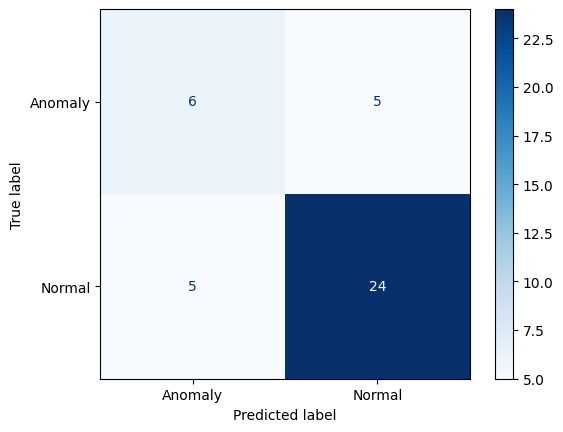

In [ ]:
y_pred_plot = y_pred.copy()
y_pred_plot[y_pred_plot == -1] = 0
y_test_plot = y_test.copy()
y_test_plot[y_test_plot == -1] = 0
cm = metrics.confusion_matrix(y_test_plot, y_pred_plot)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Anomaly','Normal'])
cmd.plot(cmap=plt.cm.Blues)

# Classifier Base (10min window)

In [ ]:
!unzip -o $PIPELINE_PATH'files_4_pipeline_10min_window.zip'
base_consolidated_time_window_train = []
base_consolidated_time_window_test = []
for _file in os.listdir(CONSOLIDATED):
  if(_file.startswith('consolidated_theia_graph_2018-04-03')):
    base_consolidated_time_window_train.append(_file)
  else:
    base_consolidated_time_window_test.append(_file)

base_consolidated_time_window_train.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))
base_consolidated_time_window_test.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))


Archive:  /content/drive/MyDrive/Caio-Paulo-GANESH/Notebooks-estudo-datasets/DARPA-E3-THEIA/Pipeline-Files/files_4_pipeline_10min_window.zip
  inflating: backbone/Backbone2018-04-12__14:15:21.654737237~~2018-04-12__14:25:21.654737237.edgelist  
  inflating: backbone/Backbone2018-04-12__10:35:21.654737237~~2018-04-12__10:45:21.654737237.edgelist  
  inflating: backbone/Backbone2018-04-10__14:24:33.000446350~~2018-04-10__14:34:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-03__10:42:14.000380070~~2018-04-03__10:52:14.000380070.edgelist  
  inflating: backbone/Backbone2018-04-10__14:54:33.000446350~~2018-04-10__15:04:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-03__11:32:14.000380070~~2018-04-03__11:42:14.000380070.edgelist  
  inflating: backbone/Backbone2018-04-10__13:04:33.000446350~~2018-04-10__13:14:33.000446350.edgelist  
  inflating: backbone/Backbone2018-04-12__10:55:21.654737237~~2018-04-12__11:05:21.654737237.edgelist  
  inflating: backbone/Backb

In [ ]:
print(len(base_consolidated_time_window_train))
print(len(base_consolidated_time_window_test))

14
40


In [ ]:
half = len(base_consolidated_time_window_train) // 2
half

7

In [ ]:
base_consolidated_time_window_train[:half]

['consolidated_theia_graph_2018-04-03__10:02:14.000380070~~2018-04-03__10:12:14.000380070',
 'consolidated_theia_graph_2018-04-03__10:12:14.000380070~~2018-04-03__10:22:14.000380070',
 'consolidated_theia_graph_2018-04-03__10:22:14.000380070~~2018-04-03__10:32:14.000380070',
 'consolidated_theia_graph_2018-04-03__10:32:14.000380070~~2018-04-03__10:42:14.000380070',
 'consolidated_theia_graph_2018-04-03__10:42:14.000380070~~2018-04-03__10:52:14.000380070',
 'consolidated_theia_graph_2018-04-03__10:52:14.000380070~~2018-04-03__11:02:14.000380070',
 'consolidated_theia_graph_2018-04-03__11:02:14.000380070~~2018-04-03__11:12:14.000380070']

In [ ]:
base_consolidated_time_window_train[half:]

['consolidated_theia_graph_2018-04-03__11:12:14.000380070~~2018-04-03__11:22:14.000380070',
 'consolidated_theia_graph_2018-04-03__11:22:14.000380070~~2018-04-03__11:32:14.000380070',
 'consolidated_theia_graph_2018-04-03__11:32:14.000380070~~2018-04-03__11:42:14.000380070',
 'consolidated_theia_graph_2018-04-03__11:42:14.000380070~~2018-04-03__11:52:14.000380070',
 'consolidated_theia_graph_2018-04-03__11:52:14.000380070~~2018-04-03__12:02:14.000380070',
 'consolidated_theia_graph_2018-04-03__12:02:14.000380070~~2018-04-03__12:12:14.000380070',
 'consolidated_theia_graph_2018-04-03__12:12:14.000380070~~2018-04-03__12:22:14.000380070']

In [ ]:
list_result_filtered = []
counter = 0
for _file_benign1 in base_consolidated_time_window_train[half:]:
  df_i_filtered = pd.read_csv(CONSOLIDATED + _file_benign1)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for _file_benign0 in base_consolidated_time_window_train[:half]:
    df_j_filtered = pd.read_csv(CONSOLIDATED + _file_benign0)
    set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
    sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
    list_result_filtered.append((_file_benign1[25:55],_file_benign0[25:55],sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['start_test', 'start_groundtruth', 'Similarity'])
filename_csv = 'similarity_base_consolidated_benign_benign.csv'
df.to_csv(filename_csv, index = False)

In [ ]:
list_result_filtered = []
counter = 0
for _file_attack0 in base_consolidated_time_window_test:
  df_i_filtered = pd.read_csv(CONSOLIDATED + _file_attack0)
  set_task_i_filtered = set(tuple(zip(df_i_filtered['src-type'],df_i_filtered['trg-type'],df_i_filtered['edge-type'])))
  for _file_benign0 in base_consolidated_time_window_train[:half]:
    df_j_filtered = pd.read_csv(CONSOLIDATED + _file_benign0)
    set_task_j_filtered = set(tuple(zip(df_j_filtered['src-type'],df_j_filtered['trg-type'],df_j_filtered['edge-type'])))
    sim_filtered = compute_sim(set_task_i_filtered, set_task_j_filtered)
    list_result_filtered.append((_file_attack0[25:55],_file_benign0[25:55],sim_filtered))

df = pd.DataFrame(list_result_filtered, columns=['start_test', 'start_groundtruth', 'Similarity'])
filename_csv = 'similarity_base_consolidated_benign_attack.csv'
df.to_csv(filename_csv, index = False)

## Moments

In [ ]:
malicious_time_windows_10 = [
  'consolidated_theia_graph_2018-04-10__13:34:33.000446350~~2018-04-10__13:44:33.000446350',
  'consolidated_theia_graph_2018-04-10__14:24:33.000446350~~2018-04-10__14:34:33.000446350',
  'consolidated_theia_graph_2018-04-10__14:34:33.000446350~~2018-04-10__14:44:33.000446350',
  'consolidated_theia_graph_2018-04-10__14:44:33.000446350~~2018-04-10__14:54:33.000446350',
  'consolidated_theia_graph_2018-04-10__14:54:33.000446350~~2018-04-10__15:04:33.000446350',
  'consolidated_theia_graph_2018-04-12__12:35:21.654737237~~2018-04-12__12:45:21.654737237',
  'consolidated_theia_graph_2018-04-12__12:45:21.654737237~~2018-04-12__12:55:21.654737237',
  'consolidated_theia_graph_2018-04-12__12:55:21.654737237~~2018-04-12__13:05:21.654737237',
  'consolidated_theia_graph_2018-04-12__13:05:21.654737237~~2018-04-12__13:15:21.654737237',
  'consolidated_theia_graph_2018-04-12__13:15:21.654737237~~2018-04-12__13:25:21.654737237',
  'consolidated_theia_graph_2018-04-12__13:25:21.654737237~~2018-04-12__13:35:21.654737237'
]

In [ ]:
base_consolidated_time_window_train = []
base_consolidated_time_window_test = []
for _file in os.listdir(CONSOLIDATED):
  if(_file.startswith('consolidated_theia_graph_2018-04-03')):
    base_consolidated_time_window_train.append(_file)
  else:
    base_consolidated_time_window_test.append(_file)

base_consolidated_time_window_train.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))
base_consolidated_time_window_test.sort(key=lambda f:int(''.join(filter(str.isdigit,f))))

In [ ]:
print(len(base_consolidated_time_window_train))
print(len(base_consolidated_time_window_test))

14
40


In [ ]:
half = len(base_consolidated_time_window_train) // 2
half

7

In [ ]:
df_benign_benign = pd.read_csv('similarity_base_consolidated_benign_benign.csv')
df_benign_attack = pd.read_csv('similarity_base_consolidated_benign_attack.csv')

In [ ]:
list_result = []
for _file_benign in base_consolidated_time_window_train[half:]:
  row = df_benign_benign[df_benign_benign['start_test'] == _file_benign[25:55]]
  M1 = row['Similarity'].mean()
  M2 = row['Similarity'].var()
  M3 = row['Similarity'].skew()
  M4 = row['Similarity'].kurtosis()
  list_result.append((M1,M2,M3,M4))
df_moment_benign = pd.DataFrame(list_result, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'])
df_moment_benign['isInlier'] = 1
df_moment_benign['isTest'] = 0


list_result = []
for _file_attack in base_consolidated_time_window_test:
  isInlier = 1
  row = df_benign_attack[df_benign_attack['start_test'] == _file_attack[25:55]]
  row = row.reset_index()
  M1 = row['Similarity'].mean()
  M2 = row['Similarity'].var()
  M3 = row['Similarity'].skew()
  M4 = row['Similarity'].kurtosis()
  if _file_attack in malicious_time_windows_10:
    isInlier = -1
  list_result.append((M1,M2,M3,M4, isInlier))
df_moment_attack = pd.DataFrame(list_result, columns=['Mean', 'Variance', 'Skewness', 'Kurtosis', 'isInlier'])
df_moment_attack['isTest'] = 1

df_moment = pd.concat([df_moment_benign, df_moment_attack])
df_moment.to_csv('base_consolidated_moments.csv', index=False)

## Classifier model

In [ ]:
df = pd.read_csv('base_consolidated_moments.csv')
df

,Mean,Variance,Skewness,Kurtosis,isInlier,isTest
0,0.994505,0.000211,-2.645751,7.0,1,0
1,0.994505,0.000211,-2.645751,7.0,1,0
2,0.994505,0.000211,-2.645751,7.0,1,0
3,0.994505,0.000211,-2.645751,7.0,1,0
4,0.994505,0.000211,-2.645751,7.0,1,0
5,0.994505,0.000211,-2.645751,7.0,1,0
6,0.994505,0.000211,-2.645751,7.0,1,0
7,0.890110,0.000211,2.645751,7.0,1,1
8,0.994505,0.000211,-2.645751,7.0,1,1
9,0.914945,0.000179,-2.645751,7.0,1,1


In [ ]:
df_train = df[df['isTest'] == 0].reset_index()
X_train = df_train[df_train.columns[1:-2]]
y_train = df_train[df_train.columns[-2]]

df_test = df[df['isTest'] == 1].reset_index()
X_test = df_test[df_test.columns[1:-2]]
y_test = df_test[df_test.columns[-2]]

In [ ]:
pipe_isolation = Pipeline([('clf', IsolationForest(random_state = 2024))])
pipe_ocsvm = Pipeline([('ocsvm', OneClassSVM())])
pipe_lof = Pipeline([('lof', LocalOutlierFactor(novelty=True))])


# Isolation Forest parameters
n_estimators_range = [5, 10, 25, 50, 100]
max_samples_range = [len(X_train) // 4, len(X_train) // 2, len(X_train)]
max_samples_range = [len(X_train) // 2, len(X_train)]
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
max_features_range = [1, 2, 3, 4]
max_features_range = [4]

# OCSVM parameters
gamma_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
nu_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

# LOF parameters
contamination_range = [0.1, 0.2, 0.3, 0.4, 0.5]
n_neighbors_range = [2, 3, 4, 5, 6, 7, 10, 15, 20]
leaf_size_range = [5, 15, 20, 25, 30, 50]



# Montagem dos parâmetros em grid
# Atente-se a sintaxe:clf__XXXXX. Indica que é um parâmetro do classificador (clf)
grid_params_isolation = [{'clf__n_estimators': n_estimators_range, 'clf__max_samples': max_samples_range,
                          'clf__contamination': contamination_range, 'clf__max_features': max_features_range}]

grid_params_ocsvm = [{'ocsvm__gamma': gamma_range, 'ocsvm__nu': nu_range}]

grid_params_lof = [{'lof__contamination': contamination_range, 'lof__n_neighbors': n_neighbors_range,
                    'lof__leaf_size': leaf_size_range}]


performance_metric = 'f1'

grid_isolation = GridSearchCV(
    estimator = pipe_isolation,
    param_grid = grid_params_isolation,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True,
    error_score = "raise"
)

grid_ocsvm = GridSearchCV(
    estimator = pipe_ocsvm,
    param_grid = grid_params_ocsvm,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True
)

grid_lof = GridSearchCV(
    estimator = pipe_lof,
    param_grid = grid_params_lof,
    scoring = performance_metric,
    n_jobs = -1,
    cv = 4,
    refit = True
)

grid_list = [grid_isolation, grid_ocsvm, grid_lof]
#grid_list = [grid_isolation]
grid_dict = {0:'Isolation Forest', 1:'OCSVM', 2:'LOF'}

print('Analisando os modelos definidos...')
best_score = 0.0
best_clf = 0
best_gs = ''

for _id, gs in enumerate(grid_list):
  print(f'\nModelo: {grid_dict[_id]}')
  gs.fit(X_train.values, y_train)
  print(f'Melhores parâmetros {gs.best_params_}')
  y_pred = gs.predict(X_test.values)
  print(classification_report(y_test, y_pred, zero_division=1.0))
  tp, fn, fp, tn = metrics.confusion_matrix(y_test,y_pred).ravel()
  print(f'TP: {tp} | FN: {fn} | FP: {fp} | TN: {tn}')

  score = get_score(y_test, y_pred, 'fscore')
  print(f'Pontuação de F1-score do conjunto de teste para os melhores parâmetros: {score}')

  if(score > best_score):
    best_score = score
    best_gs = gs
    best_clf_id = _id

print(f'\nClassificador com o melhor desempenho no conjunto de teste: {grid_dict[best_clf_id]}')

file_name = 'melhorModelo_janela10min_base_consolidated.pkl'
joblib.dump(best_gs, file_name, compress=1)
print(f'\nSalvou {grid_dict[best_clf_id]} no arquivo: {file_name}')

Analisando os modelos definidos...

Modelo: Isolation Forest
Melhores parâmetros {'clf__contamination': 0.1, 'clf__max_features': 4, 'clf__max_samples': 3, 'clf__n_estimators': 5}
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00        11
           1       0.72      1.00      0.84        29

    accuracy                           0.73        40
   macro avg       0.86      0.50      0.42        40
weighted avg       0.80      0.72      0.61        40

TP: 0 | FN: 11 | FP: 0 | TN: 29
Pontuação de F1-score do conjunto de teste para os melhores parâmetros: 0.42028985507246375

Modelo: OCSVM
Melhores parâmetros {'ocsvm__gamma': 1e-05, 'ocsvm__nu': 0.001}
              precision    recall  f1-score   support

          -1       0.28      1.00      0.43        11
           1       1.00      0.00      0.00        29

    accuracy                           0.28        40
   macro avg       0.64      0.50      0.22        40
weighted avg      

In [ ]:
#Carrega o modelo - Não só o modelo, mas todo o pipeline que foi aplicado.
file_name = 'melhorModelo_janela10min_base_consolidated.pkl'
model= joblib.load(file_name)
model.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__clf', 'estimator__clf__bootstrap', 'estimator__clf__contamination', 'estimator__clf__max_features', 'estimator__clf__max_samples', 'estimator__clf__n_estimators', 'estimator__clf__n_jobs', 'estimator__clf__random_state', 'estimator__clf__verbose', 'estimator__clf__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [ ]:
#Caso queira fazer algum teste futuro
y_pred = model.predict(X_test.values)
print(classification_report(y_test, y_pred, zero_division=1.0))

              precision    recall  f1-score   support

          -1       1.00      0.00      0.00        11
           1       0.72      1.00      0.84        29

    accuracy                           0.73        40
   macro avg       0.86      0.50      0.42        40
weighted avg       0.80      0.72      0.61        40



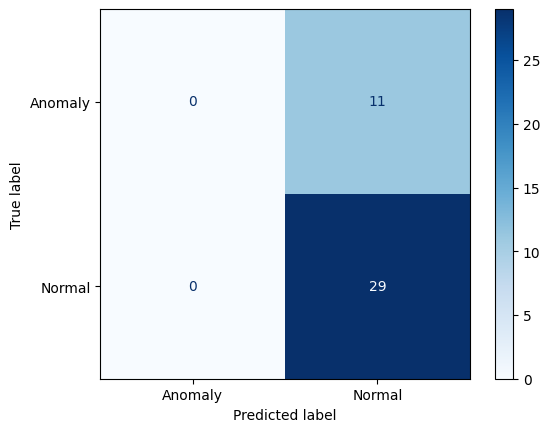

In [ ]:
y_pred_plot = y_pred.copy()
y_pred_plot[y_pred_plot == -1] = 0
y_test_plot = y_test.copy()
y_test_plot[y_test_plot == -1] = 0
cm = metrics.confusion_matrix(y_test_plot, y_pred_plot)
cmd = metrics.ConfusionMatrixDisplay(cm, display_labels=['Anomaly','Normal'])
cmd.plot(cmap=plt.cm.Blues)